In [0]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

from skimage import io, transform

import warnings
warnings.filterwarnings("ignore")

plt.ion() # for interactive mode

The dataset we are going to deal with is that of facial pose. Over all, 68 different landmark points are annotated for each face.

## 1. Reading the data from the zip file in the drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
image_path = "/gdrive/My Drive/Colab Notebooks/padh.ai.notebooks/9. CNN with PyTorch/3. PyTorch Official Tutorial/2. Data Loading and preprocessing"
os.chdir(image_path)
os.listdir(image_path)

['faces.zip', 'faces', 'data_loading_preprocessing.ipynb']

In [0]:
file = 'faces.zip'
if not os.path.exists('faces'):
  file = zipfile.ZipFile(file,'r')
  file.extractall(image_path)
  file.close()

root_dir = os.path.join(image_path, 'faces')
os.listdir(image_path)

['faces.zip', 'faces', 'data_loading_preprocessing.ipynb']

In [0]:
face_data = os.path.join('faces','face_landmarks.csv')
face_data = pd.read_csv(face_data)
print('Total number of records:',len(face_data))
face_data.head()

Total number of records: 69


,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


## 2. Displaying the image data

In [0]:
index = np.random.randint(0,len(face_data))
image_name = face_data.iloc[index,0]
landmarks = face_data.iloc[index,1:].as_matrix().astype('float').reshape(-1,2) # sorting all xs and ys in dedicated x and y columns
landmarks.shape

(68, 2)

In [0]:
image_read = io.imread(os.path.join('faces',image_name))
image_read.shape

(333, 500, 3)

**Note:** All the images are of different shapes

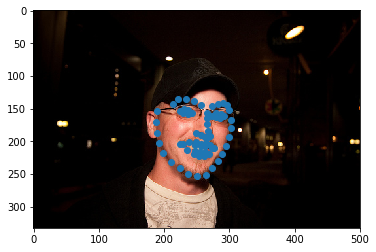

In [0]:
def show_image(image_name):
  image_read = io.imread(os.path.join('faces',image_name))
  plt.imshow(image_read)
  plt.scatter(landmarks[:,0], landmarks[:,1])
  plt.show()

show_image(image_name)

## 3. Data Preprocessing using PyTorch 

In [0]:
class FaceLandmarkDataset(Dataset):
  
  def __init__(self, csv_file, root_dir, transform=None):
    
    self.root_dir = root_dir
    self.landmark_frame = pd.read_csv(os.path.join(root_dir,csv_file))
    self.transform = transform
    
  def __len__(self):
    return len(self.landmark_frame)
  
  def __getitem__(self, idx):
    image_name = self.landmark_frame.iloc[idx,0]
    image = io.imread(os.path.join(self.root_dir,image_name))
    landmarks = self.landmark_frame.iloc[idx,1:].values.astype('float').reshape(-1,2)
    sample = {'image':image, 'landmarks':landmarks}
    
    if self.transform:
      sample = self.transform(sample)
      
    return sample
  
face_dataset = FaceLandmarkDataset('face_landmarks.csv',root_dir)

0  | Pixel size: (324, 215, 3) (68, 2)
1  | Pixel size: (500, 333, 3) (68, 2)
2  | Pixel size: (250, 258, 3) (68, 2)
3  | Pixel size: (434, 290, 3) (68, 2)
4  | Pixel size: (828, 630, 3) (68, 2)
5  | Pixel size: (402, 500, 3) (68, 2)


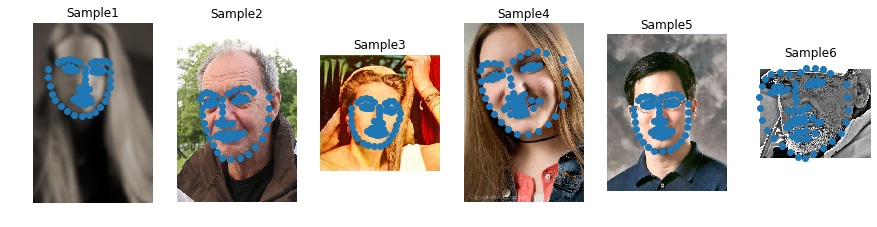

In [0]:
def display_images(dataset,display_image = 5):
  fig = plt.figure(figsize=(15,10))
  for i in range(len(dataset)):

    sample = dataset[i] # this calls the __getitem__(idx) method

    print(i,' | Pixel size:',sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1,display_image+1,i+1)

    img = sample['image']
    ax.imshow(img)
    plt.scatter(sample['landmarks'][:,0], sample['landmarks'][:,1])
    ax.set_title('Sample'+str(i+1))
    ax.axis('off')

    if i == display_image:
      plt.show()
      break
      
display_images(face_dataset,display_image = 5)      

## 4. Transforms

One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some prepocessing code

- **Rescale** - to scale the image to standard size
- **RandomCrop** - to crop from image randomly. This is data augmentation
- **ToTensor** - to convert the numpy images to tensors

In [0]:
class Rescale(object):
  
  def __init__(self, output_size):
    assert isinstance(output_size, (int,tuple))
    self.output_size = output_size
    
  def __call__(self,sample):
    image, landmarks = sample['image'], sample['landmarks']
    h, w = image.shape[:2]
    if isinstance(self.output_size, int):
      if h>w:
        new_h, new_w = self.output_size*h/w, self.output_size
      else:
        new_h, new_w = self.output_size, self.output_size*w/h

    else:
      new_h, new_w = self.output_size, self.output_size

    new_h, new_w = int(new_h), int(new_w)

    image = transform.resize(image, (new_h,new_w,3))
    landmarks =  landmarks*[new_w/w, new_h/h]
    
    return {'image':image, 'landmarks':landmarks}
  

class Random_Crop(object):

  def __init__(self, output_size):
    assert isinstance(output_size, (int,tuple))
    self.output_size = output_size

  def __call__(self,sample):
    image = sample['image']
    landmarks = sample['landmarks']
    h,w = image.shape[:2]
    new_h, new_w = self.output_size, self.output_size
    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top: top + new_h,
                  left: left + new_w]
    

    landmarks = landmarks - [left, top]
    return {'image': image, 'landmarks': landmarks}

In [0]:
class To_Tensor(object):
  
  def __call__(self, sample):
    image = np.transpose(sample['image'], (2,0,1))
    return {'image':torch.from_numpy(image), 'landmarks':torch.from_numpy(sample['landmarks'])}

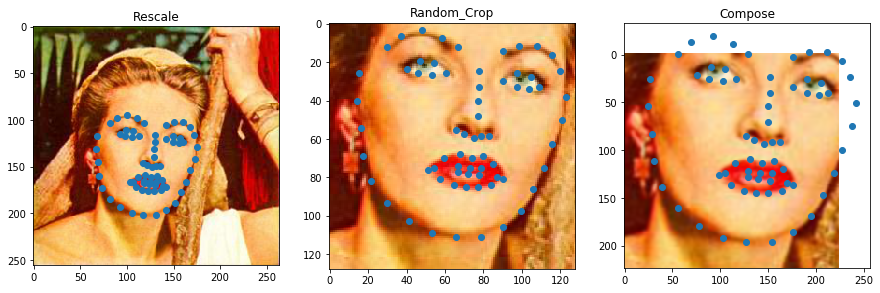

In [0]:
sample = face_dataset[2]
fig = plt.figure(figsize=(15,10))
rescale = Rescale(256)
random_crop = Random_Crop(128)
compose = transforms.Compose([Rescale(256), Random_Crop(224)])

for i,operation in enumerate([rescale, random_crop, compose]):
  ax = plt.subplot(1,3,i+1)
  sample = operation(sample)
  image, landmarks = sample['image'], sample['landmarks']
  ax.imshow(image)
  ax.scatter(landmarks[:,0], landmarks[:,1])
  ax.set_title(type(operation).__name__)
plt.show()
  

## 5. Iterating through the dataset, applying the image transformation and concatenating the dataset with augmented datasets

- An image is read from the file on the fly
- Transforms are applied on the read image
- **Since one of the transforms is random, data is augmentated on sampling**

In [0]:
transformation = transforms.Compose([
    Rescale(256),
    Random_Crop(224),
    To_Tensor()
])

transformed_data = FaceLandmarkDataset('face_landmarks.csv',root_dir, transform = transformation)
original_data = FaceLandmarkDataset('face_landmarks.csv', root_dir, transform = To_Tensor())

for i in range(len(transformed_data)):
  sample = transformed_data[i]
  print(sample['image'].size(), sample['landmarks'].size())
  if i == 10:
    break
    


torch.Size([3, 224, 224]) torch.Size([68, 2])
torch.Size([3, 224, 224]) torch.Size([68, 2])
torch.Size([3, 224, 224]) torch.Size([68, 2])
torch.Size([3, 224, 224]) torch.Size([68, 2])
torch.Size([3, 224, 224]) torch.Size([68, 2])
torch.Size([3, 224, 224]) torch.Size([68, 2])
torch.Size([3, 224, 224]) torch.Size([68, 2])
torch.Size([3, 224, 224]) torch.Size([68, 2])
torch.Size([3, 224, 224]) torch.Size([68, 2])
torch.Size([3, 224, 224]) torch.Size([68, 2])
torch.Size([3, 224, 224]) torch.Size([68, 2])


In [0]:
print('Total length of the original dataset:',len(original_data))
print('Total length of the transformed dataset:',len(transformed_data))

Total length of the original dataset: 69
Total length of the transformed dataset: 69


The data augmentation using the torchvision.transform will not create any new data but will transform the original one and return the same size

In [0]:
def return_all_items(dataset):
  all_items = []
  for i in range(len(dataset)):
    all_items.append(dataset[i])
  return all_items

In [0]:
list1 = return_all_items(original_data)
list2 = return_all_items(transformed_data)
list1.extend(list2)

In [0]:
class AugmentedDataset(Dataset):
  
  def __init__(self, combined_list, transform=None):
    self.combined_list = combined_list
    
  def __len__(self):
    return len(self.combined_list)
  
  def __getitem__(self, idx):
    sample = self.combined_list[idx]      
    return sample
  
augmented_dataset = AugmentedDataset(list1)

The number of images in the combined original and augmented dataset: 138
(224, 224, 3)


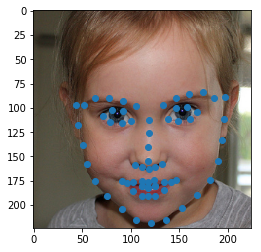

In [0]:
augmented_data_loader = DataLoader(augmented_dataset, shuffle=True)
print('The number of images in the combined original and augmented dataset:',len(augmented_data_loader))
dataiter = iter(augmented_data_loader)
sample = dataiter.next()



img = sample['image'][0].numpy()
img = np.transpose(img, (1,2,0))
landmarks = sample['landmarks'][0].numpy()
print(img.shape)
plt.imshow(img)

plt.scatter(landmarks[:,0], landmarks[:,1])
plt.show()

In [0]:
transformed_data_loader = DataLoader(augmented_dataset, shuffle=True)
original_data_loader = DataLoader(face_dataset, shuffle=True)

dataiter_transformed = iter(transformed_data_loader)
dataiter_original = iter(original_data_loader)

sample1 = dataiter_transformed.next()
sample2 = dataiter_original.next()

sample1['image'].shape, sample2['image'].shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 500, 375, 3]))

## 6. Transformation using torchvision package

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

In [0]:
data_transform = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

face_dataset_transformed = FaceLandmarkDataset('face_landmarks.csv',root_dir, transform = data_transform)
dataset_loader = DataLoader(face_dataset_transformed, batch_size = 4, num_workers=4, shuffle=True)